In [98]:
import os
from glob import glob
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [109]:
def create_file_existence_df(root_dir, files):
    dfs = []
    
    for root, dirs, files_in_folder in os.walk(root_dir):
        folder_data = []
        
        for file in files:
            folder_data.append({
                'dataset': os.path.basename(root),
                'type': file,
                'exists': file in files_in_folder
            })
        
        # Create a DataFrame for the current folder
        df = pd.DataFrame(folder_data)
        dfs.append(df)
    
    # Concatenate all DataFrames into one
    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[~final_df['dataset'].str.contains('outdata', case=False, na=False)]
    return final_df

def participant_col_list(file_list):
    col_list_df = pd.DataFrame(columns=['study_id', 'column_name'])

    for file in file_list:
        study_id = file.split('/')[-2]
        
        # Attempt to read the file with different encodings
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        data_rows = [{'study_id': study_id, 'column_name': col} for col in dat.columns]

        # Concatenate data
        col_list_df = pd.concat([col_list_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return col_list_df

def participant_col_values(file_list, col_list):
    results_df = pd.DataFrame(columns=['study_id', 'column_name', 'values'])

    # lowercase for case-insensitive matching
    columns_lowcase = [col.lower() for col in col_list]

    for file in file_list:
        study_id = file.split('/')[-2]
        
        # Attempt to read the file with different encodings
        try:
            dat = pd.read_csv(file, sep='\t', encoding='utf-8')
        except Exception:
            try:
                dat = pd.read_csv(file, sep='\t', on_bad_lines='warn')
            except Exception:
                dat = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
        
        # Convert column names to lowercase for case-insensitive comparison
        columns_lower = {col.lower(): col for col in dat.columns}
        
        # Find the intersection of target columns with actual columns in the dataframe
        matching_columns = set(columns_lowcase) & set(columns_lower.keys())
        
        # Extract the data for matching columns
        for col_lower in matching_columns:
            actual_col_name = columns_lower[col_lower]
            values = dat[actual_col_name].tolist()  # Convert column values to a list
            
            # Create rows for the DataFrame
            data_rows = [{'study_id': study_id, 
                          'column_name': actual_col_name, 
                          'values': value} for value in values]
            
            # Concatenate data
            results_df = pd.concat([results_df, pd.DataFrame(data_rows)], ignore_index=True)
    
    return results_df


In [32]:
outdata ='/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/outdata'
opne_folders = glob(f'{outdata}/*')
len(opne_folders)


1152

In [39]:
files_to_check = ["participants.json", "participants.tsv", "dataset_description.json"]

file_existence_df = create_file_existence_df(outdata, files_to_check)

# Save the DataFrame to a CSV file
file_existence_df.to_csv('file_existence_summary.csv', index=False)

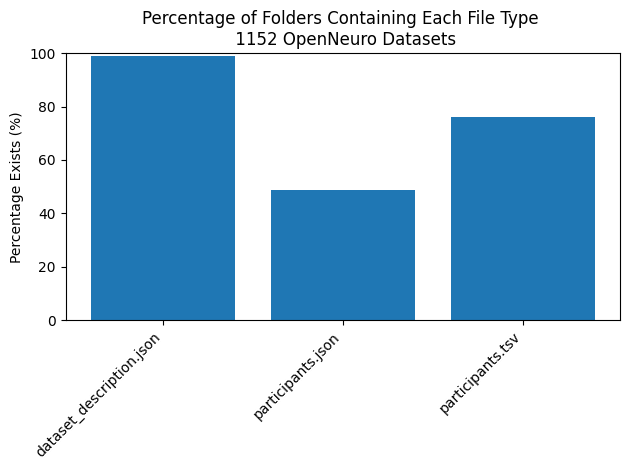

In [42]:
percent_type = file_existence_df.groupby('type')['exists'].mean() * 100
percent_type = percent_type.reset_index()
percent_type.columns = ['type','percent']
plt.bar(percent_type['type'], percent_type['percent'])
plt.xlabel('')
plt.ylabel('Percentage Exists (%)')
plt.title(f'Percentage of Folders Containing Each File Type \n {len(opne_folders)} OpenNeuro Datasets')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

In [61]:
file_list = glob(f'{outdata}/**/participants.tsv')
len(file_list), file_list[0].split('/')[-2]

(878, 'ds005238')

In [106]:
columns_df = participant_col_list(file_list)

b'Skipping line 14: expected 16 fields, saw 17\n'


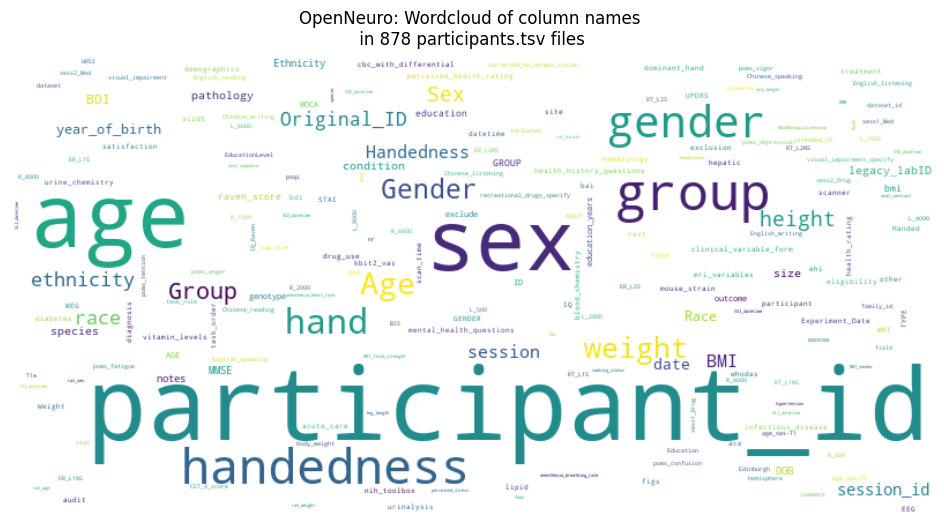

In [107]:
freq_words = Counter(columns_df['column_name'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(freq_words)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'OpenNeuro: Wordcloud of column names \n in {len(file_list)} participants.tsv files ')
plt.show()

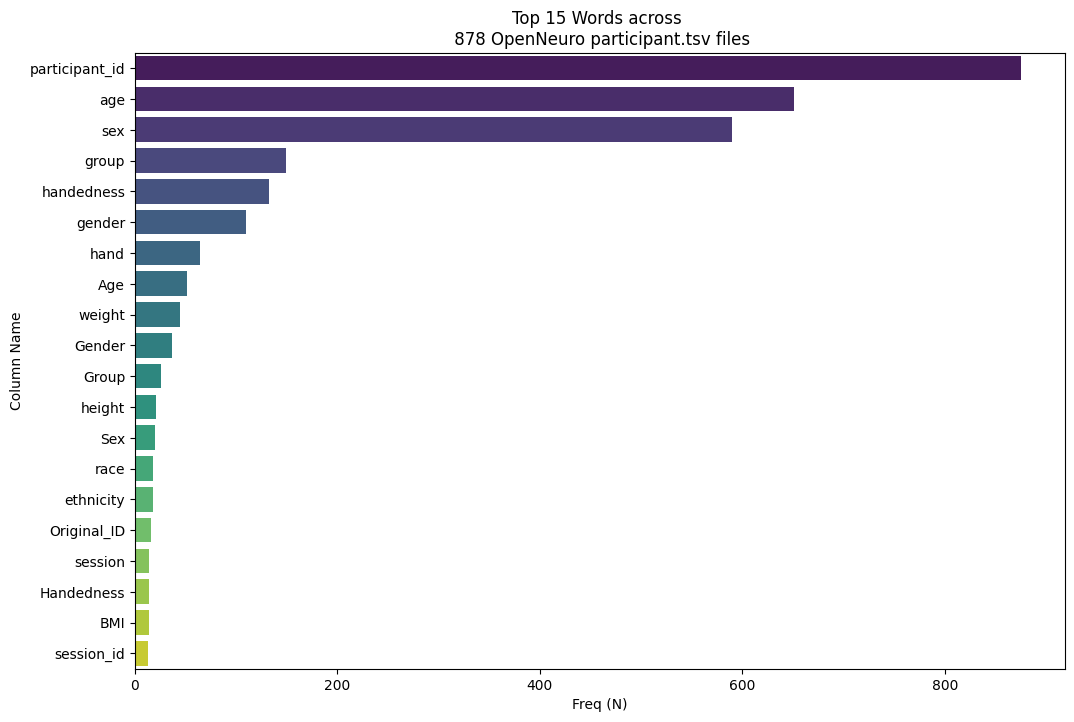

In [108]:
freq_words = Counter(columns_df['column_name'])

# pick top 20
top_15_words = dict(freq_words.most_common(20))

top_words_df = pd.DataFrame(list(top_15_words.items()), columns=['name', 'freq'])

# freq top 15 
plt.figure(figsize=(12, 8))
sns.barplot(data=top_words_df, y='name', x='freq', palette='viridis')
plt.title(f'Top 15 Words across \n {len(file_list)} OpenNeuro participant.tsv files')
plt.xlabel('Freq (N)')
plt.ylabel('Column Name')
plt.show()

In [110]:
columns_name_eval = ['age','sex','gender','handedness','hand']
columns_values_df = participant_col_values(file_list,columns_name_eval)

b'Skipping line 14: expected 16 fields, saw 17\n'


In [113]:
columns_values_df.groupby('')

,study_id,column_name,values
0,ds005238,age,19
1,ds005238,age,19
2,ds005238,age,19
3,ds005238,age,29
4,ds005238,age,29
...,...,...,...
108419,ds005085,sex,F
108420,ds005085,sex,F
108421,ds005085,sex,F
108422,ds005085,sex,F


In [ ]:
filtered_df = df[df['sex'] == 'M']